# GDP and ESI lag/trend Modelling Experiments

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import statsmodels.api as sm

from pathlib import Path

In [2]:
from statsmodels import __version__
__version__

'0.10.1'

In [3]:
# Set up environment
pd.plotting.register_matplotlib_converters()
np.random.seed(42)

In [4]:
path_data = Path(".").absolute().parent / "data"
path_xl = path_data / "ESI_GDP.xlsx"

In [5]:
path_output = Path(".").absolute().parent / "output" / pd.Timestamp.now().strftime("%Y-%m-%d")
path_output.mkdir(exist_ok=True, parents=True)

# Preparation

## Load data

In [6]:
df = pd.read_excel(path_xl)
df.index = df.index.to_series().apply(lambda x: pd.datetime.strptime(x, '%YM%m'))
df.dropna().head()

,GGDP,GESI,GESISA,GGDPSA
2006-05-01,110.800000,106.863298,106.816640,109.458524
2006-06-01,109.258365,106.396667,106.327908,109.290571
2006-07-01,109.859167,104.883275,104.541073,109.045494
2006-08-01,108.508595,101.666480,101.486939,109.335025
2006-09-01,107.968031,99.242416,101.525884,107.570909


In [7]:
ggdp = df["GGDP"]
gesi = df["GESI"]

## Seasonal adjustment (via X13-ARIMA-SEATS)

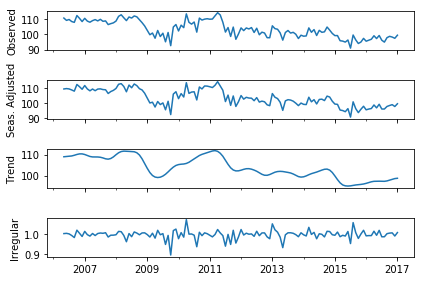

In [8]:
x13_gdp = sm.tsa.x13_arima_analysis(ggdp.dropna())
gdp_sa = x13_gdp.seasadj
x13_gdp.plot();

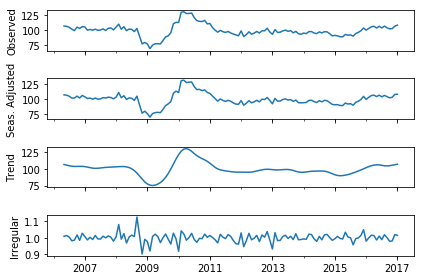

In [9]:
x13_esi = sm.tsa.x13_arima_analysis(gesi.dropna())
esi_sa = x13_esi.seasadj
x13_esi.plot();

## Assemble dataset

In [10]:
e4 = esi_sa.tshift(4)
e4.head()

2006-09-01    106.942781
2006-10-01    106.416458
2006-11-01    104.651012
2006-12-01    101.612297
2007-01-01    101.684418
Freq: MS, Name: seasadj, dtype: float64

In [11]:
data = pd.concat(
    [gdp_sa.rename("gdp_sa"), esi_sa.rename("esi_sa"), e4.rename("esi_sa_4")], axis="columns"
).dropna(axis="rows")
data['c'] = 1
data['t'] = range(len(data))
pd.concat([data.head(), data.tail()])

,gdp_sa,esi_sa,esi_sa_4,c,t
2006-09-01,107.818316,101.684418,106.942781,1,0
2006-10-01,112.205728,104.856532,106.416458,1,1
2006-11-01,110.749865,101.681628,104.651012,1,2
2006-12-01,109.066078,106.019716,101.612297,1,3
2007-01-01,111.526153,103.606956,101.684418,1,4
2016-09-01,97.738588,104.005035,104.127821,1,120
2016-10-01,98.381886,102.029245,106.423659,1,121
2016-11-01,98.929566,102.895920,103.613860,1,122
2016-12-01,97.712345,107.735059,106.077786,1,123
2017-01-01,99.527172,107.938334,104.005035,1,124


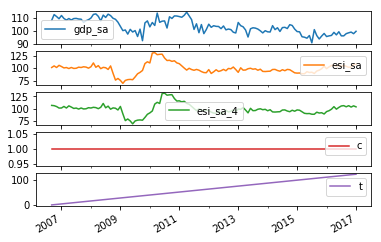

In [12]:
data.plot.line(subplots=True);

In [13]:
cutoff = '2016-10-01'
cutoff_idx = np.argmax(data.index == cutoff)

In [14]:
actuals = data["gdp_sa"]

## General Function

In [15]:
exog_var_map = {
    'c': 'Constant',
    't': 'Linear trend (t)',
    'esi_sa': 'GESI_SA[-0] (seasonally adjusted by X13)',
    'esi_sa_4': 'GESI_SA[-4] (seasonally adjusted by X13)',    
}

In [16]:
def get_stationary_from_coef(coefs: pd.DataFrame) -> np.array:
    # HACK: Only works for 2 states
    p00, p10 = coefs.loc[['p[0->0]','p[1->0]'],'value']
    A = np.array([[p00, 1 - p00], [p10, 1 - p10]])
    evals, evecs = np.linalg.eig(A.T)
    evec1 = evecs[:,np.isclose(evals, 1)]
    evec1 = evec1[:,0]
    stationary = (evec1 / evec1.sum()).real
    return stationary

In [17]:
def do_everything(
    exog_vars: list = ["t"], plot_title: str = "Model fit", output_to: Path = None
):
    # Prepare output directory
    if output_to is not None:
        output_to = Path(output_to).absolute()
        output_to.mkdir(exist_ok=True, parents=True)

    # Create template with full data
    model_template = sm.tsa.MarkovRegression(
        endog=actuals, k_regimes=2, exog=data[exog_vars]
    )

    # Fit model only train data
    mdl = sm.tsa.MarkovRegression(
        endog=actuals.iloc[:cutoff_idx],
        k_regimes=2,
        exog=data[exog_vars].iloc[:cutoff_idx],
    ).fit(search_reps=200, em_iter=20, disp=True)

    # Get coefficients
    coef = pd.DataFrame(
        {
            "value": mdl.params,
            "std": pd.Series(np.sqrt(np.diag(mdl.cov_params())), mdl.params.index),
            "z": mdl.tvalues,
        }
    )

    # Get dataframe of predictions
    pred_ins = pd.Series(
        mdl.predict(),
        index=data.index[:cutoff_idx],
        name="Conditional Mean (In-sample)",
    )
    pred_oos = pd.Series(
        model_template.predict(mdl.params, start=cutoff),
        index=data.index[cutoff_idx:],
        name="OOS Mean",
    )
    pred_cond = pd.DataFrame(
        model_template.predict(mdl.params, conditional=True)[:, cutoff_idx:].T,
        index=data.index[cutoff_idx:],
        columns=["Regime 0", "Regime 1"],
    )
    pred_all = pd.concat([pred_ins, pred_oos], axis="rows")
    df = pd.DataFrame(
        {
            "actual": actuals,
            "pred": pred_all,
            "resid": actuals - pred_all,
            "prob_raw": pd.Series(
                mdl.predicted_marginal_probabilities[0], index=data.index[:cutoff_idx]
            ),
            "prob_filtered": mdl.filtered_marginal_probabilities[0],
            "prob_smoothed": mdl.smoothed_marginal_probabilities[0],
        }
    )
    df = pd.concat([df, pred_cond], axis="columns")
    durbin_watson = np.round(sm.stats.stattools.durbin_watson(df.resid), 3)

    # Write coefficients to excel
    if output_to is not None:
        writer = pd.ExcelWriter(output_to / "results.xlsx")
        with writer:
            df.to_excel(writer, sheet_name="Results")
            coef.to_excel(writer, sheet_name="Coefficients")

    # SUMMARY
    summary = mdl.summary()

    _tbl_vals = [["const", exog_var_map["c"]]] + [
        [f"x{i+1}", exog_var_map[k]] for i, k in enumerate(exog_vars)
    ]

    # Add variable information
    tbl_variables = sm.iolib.table.SimpleTable(
        _tbl_vals, headers=["Variable", "Name"], title="Variable information"
    )
    summary.tables.insert(1, tbl_variables)

    # Add regime information
    stationary = get_stationary_from_coef(coef)
    tbl_regimes = sm.iolib.table.SimpleTable(
        [[i, np.round(stationary[i], 3), np.round(mdl.expected_durations[i], 3)] for i in range(2)],
        headers=["Regime", "Ergodic probability", "Expected Duration"],
        title="Other regime information",
    )
    summary.tables.append(tbl_regimes)

    # Other
    tbl_other_stats = sm.iolib.table.SimpleTable(
        [["Durbin-Watson", durbin_watson]],
        headers=["Statistic", "Value"],
        title="Other statistics",
    )
    summary.tables.append(tbl_other_stats)

    # Get rid of warning text at end
    summary.add_extra_txt([])

    # Write to file
    if output_to is not None:
        with (output_to / "summary.txt").open("w") as f:
            f.write(summary.as_text())

    # Main plot
    fig, ax = plt.subplots(3, 1, figsize=(18, 12))
    ax[0].set_title(plot_title)
    df.actual.plot.line(ax=ax[0], color="C0", label="Actual")
    df.pred.plot.line(ax=ax[0], color="C1", label="Predicted")
    ax[0].axvline(cutoff, linestyle='--', color='Black', label='Sample End')
    pred_cond.plot.line(ax=ax[0], color=['red', 'purple'])
    ax[0].legend()
    ax[1].set_title("Prob of regime")
    df.prob_raw.plot.line(ax=ax[1], color="green", label="Raw Prob")
    df.prob_filtered.plot.line(ax=ax[1], color="orange", label="Filtered Prob")
    df.prob_smoothed.plot.line(ax=ax[1], color="red", label="Smoothed Prob")
    ax[1].fill_between(
        df.prob_raw.index,
        0,
        (df.prob_raw > 0.5).astype(int),
        color="grey",
        alpha=0.5,
        label="Regime 0",
    )
    ax[1].legend()
    ax[2].set_title("Residuals")
    df.resid.plot.line(ax=ax[2], color="C2")
    if output_to is not None:
        fig.savefig(output_to / "model_fits.png")

    # Residual QQ plot
    fig_resid_qq, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.set_title("Q-Q Plot of Residuals (Normal)")
    sm.graphics.qqplot(df.resid / np.std(df.resid), line="45", ax=ax)
    if output_to is not None:
        fig_resid_qq.savefig(output_to / "resid_qq.png")

    # Residual ACF/PACF plots
    fig_resid_acf, ax = plt.subplots(2, 2, figsize=(12, 8))
    sm.tsa.graphics.plot_acf(df.resid, ax=ax[0, 0], title="Residual Autocorrelation")
    sm.tsa.graphics.plot_pacf(df.resid, ax=ax[0, 1], title="Residual PACF")
    sm.tsa.graphics.plot_acf(df.resid ** 2, ax=ax[1, 0], title="Squared Residual ACF")
    sm.tsa.graphics.plot_pacf(df.resid ** 2, ax=ax[1, 1], title="Squared Residual PACF")
    fig_resid_acf.suptitle("Residual diagnostics")
    if output_to is not None:
        fig_resid_acf.savefig(output_to / "resid_acf.png")

    return dict(
        template=model_template,
        model=mdl,
        coef=coef,
        summary=summary,
        df=df,
        durbin_watson=durbin_watson,
        fig=fig,
        fig_resid_qq=fig_resid_qq,
        fig_resid_acf=fig_resid_acf,
    )

# Run Models

## ESI_SA\[0\]

Optimization terminated successfully.
         Current function value: 2.620826
         Iterations: 14
         Function evaluations: 19
         Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 gdp_sa   No. Observations:                  121
Model:               MarkovRegression   Log Likelihood                -317.120
Date:                Thu, 06 Feb 2020   AIC                            648.240
Time:                        02:33:53   BIC                            667.810
Sample:                    09-01-2006   HQIC                           656.188
                         - 09-01-2016                                         
Covariance Type:               approx                                         
               Variable information              
=================================================
Variable                   Name                  
-------------------------------------------------
   const                                 Constant
      x1 GESI_SA[-0] (seasonally adjusted by X13)
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        115.0213      4.431     25.960      0.000     106.337     123.705
x1            -0.0553      0.041     -1.337      0.181      -0.136       0.026
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.1950      4.742     21.764      0.000      93.902     112.488
x1            -0.0360      0.050     -0.719      0.472      -0.134       0.062
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.8987      1.166      7.634      0.000       6.614      11.183
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9695      0.024     41.014      0.000       0.923       1.016
p[1->0]        0.0220      0.016      1.349      0.177      -0.010       0.054
          Other regime information          
============================================
Regime Ergodic probability Expected Duration
--------------------------------------------
     0               0.418            32.754
     1               0.582            45.536
  Other statistics 
===================
  Statistic   Value
-------------------
Durbin-Watson 1.255
-------------------


"""

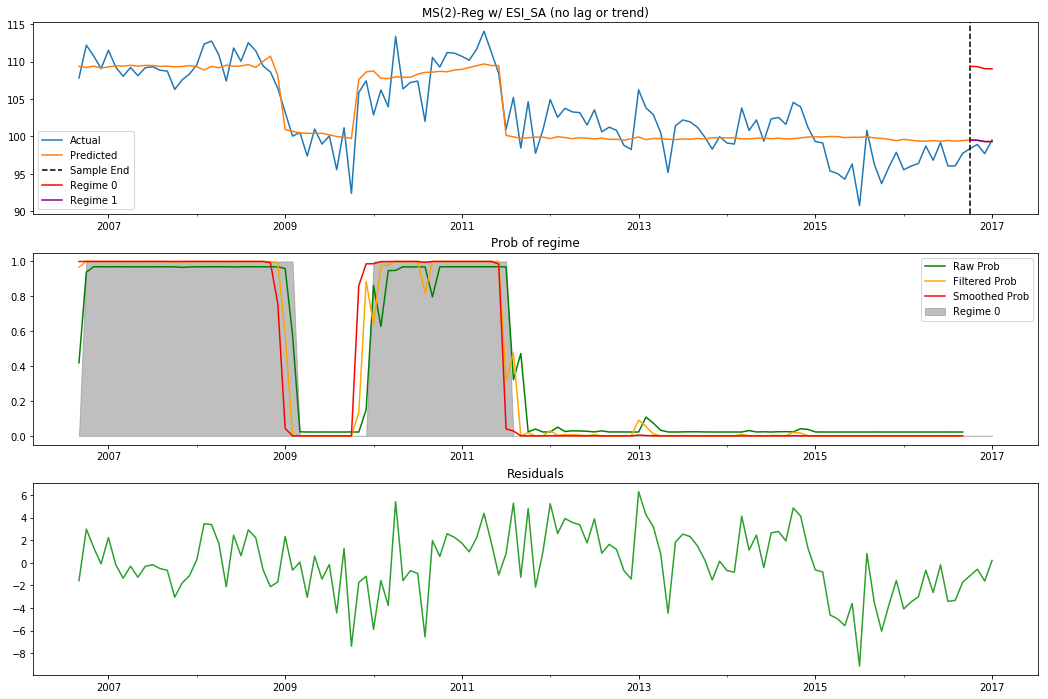

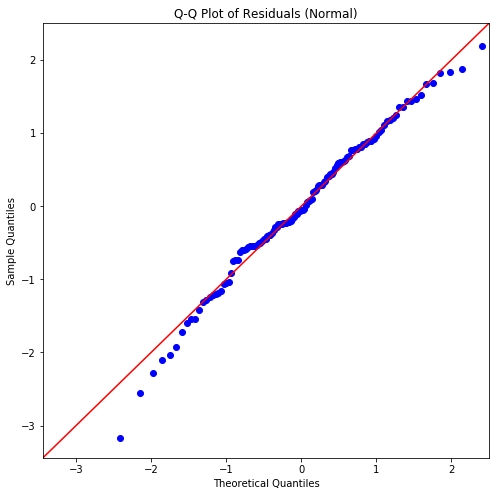

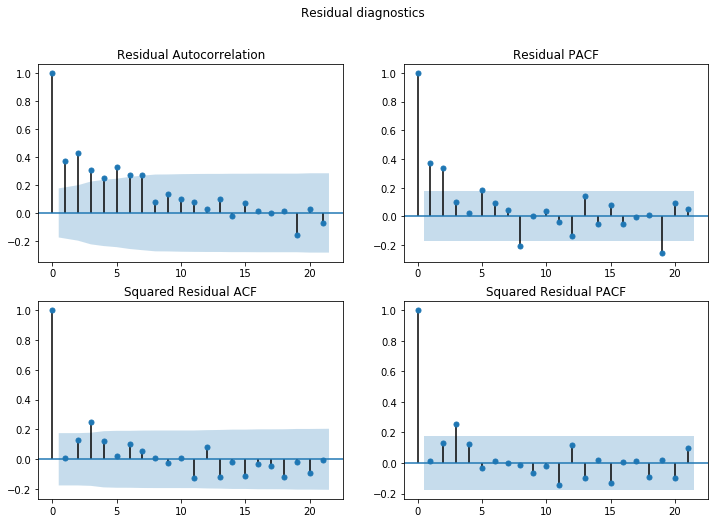

In [18]:
all_only_esi0 = do_everything(
    exog_vars=["esi_sa"],
    plot_title="MS(2)-Reg w/ ESI_SA (no lag or trend)",
    output_to=path_output / "only_esi_0",
)
all_only_esi0['summary']

## ESI_SA\[-4\]

Optimization terminated successfully.
         Current function value: 2.615559
         Iterations: 32
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 gdp_sa   No. Observations:                  121
Model:               MarkovRegression   Log Likelihood                -316.483
Date:                Thu, 06 Feb 2020   AIC                            646.965
Time:                        02:33:56   BIC                            666.536
Sample:                    09-01-2006   HQIC                           654.914
                         - 09-01-2016                                         
Covariance Type:               approx                                         
               Variable information              
=================================================
Variable                   Name                  
-------------------------------------------------
   const                                 Constant
      x1 GESI_SA[-4] (seasonally adjusted by X13)
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.6983      4.664     22.661      0.000      96.556     114.840
x1             0.0321      0.043      0.739      0.460      -0.053       0.117
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.1214      4.462     20.645      0.000      83.376     100.867
x1             0.0813      0.047      1.720      0.086      -0.011       0.174
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.8167      1.163      7.583      0.000       6.538      11.096
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9686      0.024     39.632      0.000       0.921       1.017
p[1->0]        0.0227      0.017      1.343      0.179      -0.010       0.056
          Other regime information          
============================================
Regime Ergodic probability Expected Duration
--------------------------------------------
     0                0.42            31.872
     1                0.58            44.104
  Other statistics 
===================
  Statistic   Value
-------------------
Durbin-Watson 1.179
-------------------


"""

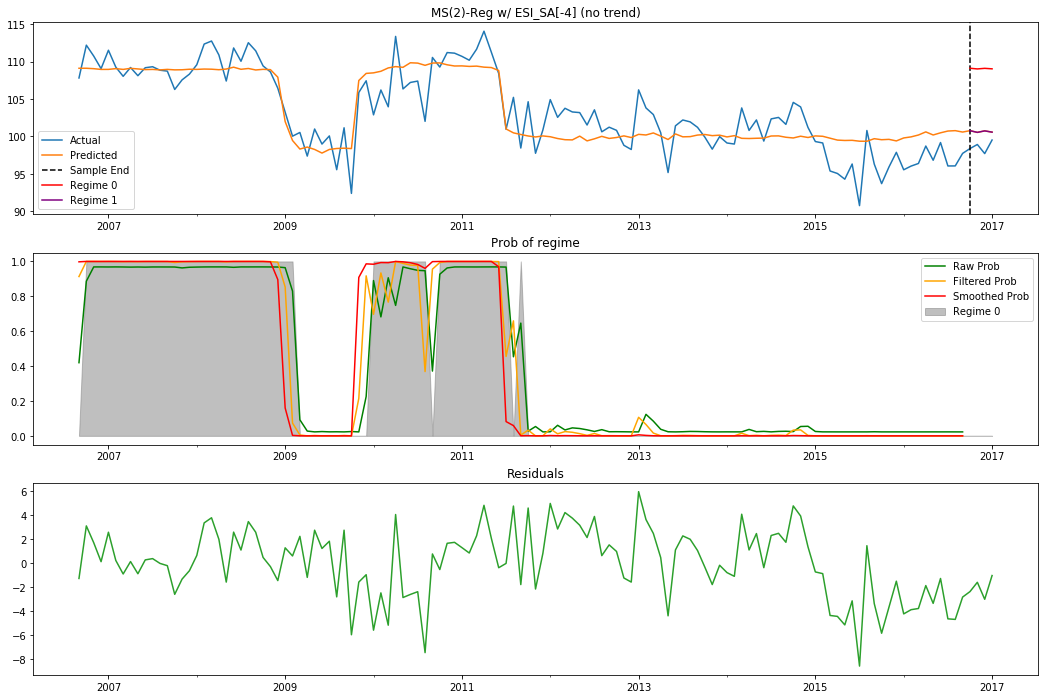

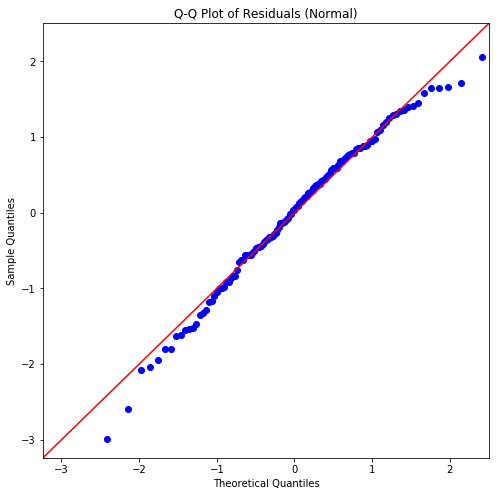

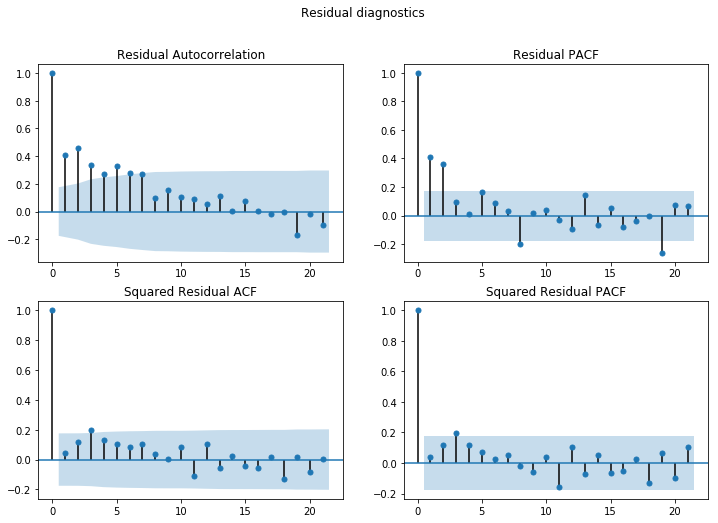

In [19]:
all_only_esi4 = do_everything(
    exog_vars=["esi_sa_4"],
    plot_title="MS(2)-Reg w/ ESI_SA[-4] (no trend)",
    output_to=path_output / "only_esi_4",
)
all_only_esi4['summary']

## Trend only

Optimization terminated successfully.
         Current function value: 2.576425
         Iterations: 24
         Function evaluations: 30
         Gradient evaluations: 30


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 gdp_sa   No. Observations:                  121
Model:               MarkovRegression   Log Likelihood                -311.747
Date:                Thu, 06 Feb 2020   AIC                            637.495
Time:                        02:33:59   BIC                            657.065
Sample:                    09-01-2006   HQIC                           645.443
                         - 09-01-2016                                         
Covariance Type:               approx                                         
   Variable information  
=========================
Variable       Name      
-------------------------
   const         Constant
      x1 Linear trend (t)
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.3309      1.096     95.228      0.000     102.184     106.478
x1            -0.0536      0.013     -4.150      0.000      -0.079      -0.028
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.4102      0.762    143.671      0.000     107.918     110.903
x1             0.0050      0.025      0.202      0.840      -0.043       0.053
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.2812      1.093      7.578      0.000       6.139      10.423
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9784      0.016     61.393      0.000       0.947       1.010
p[1->0]        0.0343      0.027      1.271      0.204      -0.019       0.087
          Other regime information          
============================================
Regime Ergodic probability Expected Duration
--------------------------------------------
     0               0.614            46.323
     1               0.386            29.137
  Other statistics 
===================
  Statistic   Value
-------------------
Durbin-Watson 1.403
-------------------


"""

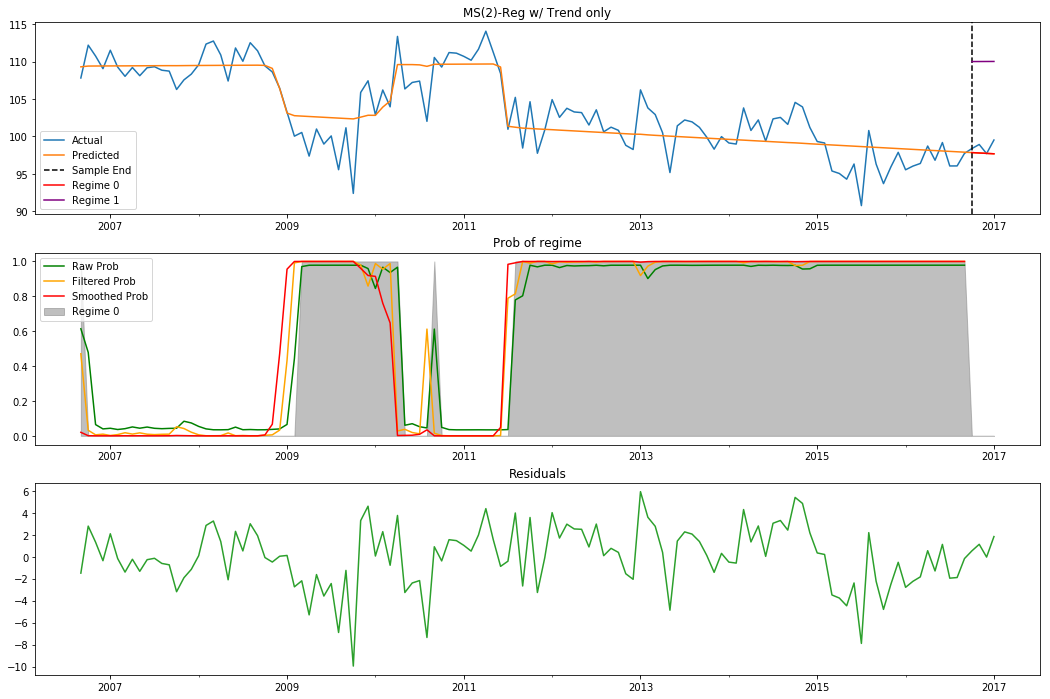

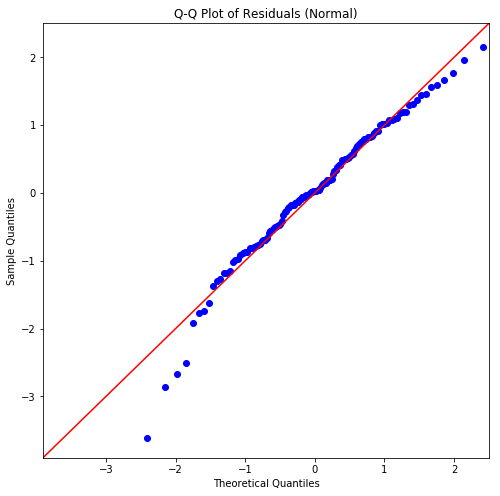

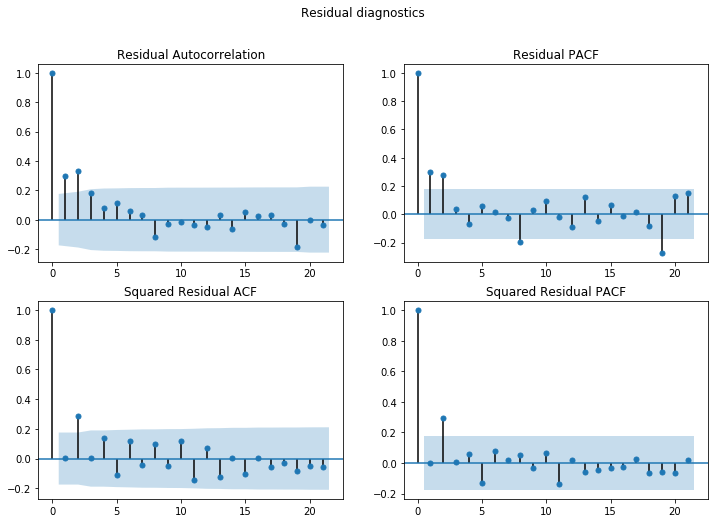

In [20]:
all_trend_only = do_everything(
    exog_vars=["t"],
    plot_title="MS(2)-Reg w/ Trend only",
    output_to=path_output / "trend_only",
)
all_trend_only['summary']

## Trend and ESI_SA\[0\]

Optimization terminated successfully.
         Current function value: 2.505804
         Iterations: 36
         Function evaluations: 42
         Gradient evaluations: 42


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 gdp_sa   No. Observations:                  121
Model:               MarkovRegression   Log Likelihood                -303.202
Date:                Thu, 06 Feb 2020   AIC                            624.405
Time:                        02:34:02   BIC                            649.567
Sample:                    09-01-2006   HQIC                           634.624
                         - 09-01-2016                                         
Covariance Type:               approx                                         
               Variable information              
=================================================
Variable                   Name                  
-------------------------------------------------
   const                                 Constant
      x1                         Linear trend (t)
      x2 GESI_SA[-0] (seasonally adjusted by X13)
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.6467      6.654     15.276      0.000      88.605     114.689
x1             0.0256      0.024      1.061      0.289      -0.022       0.073
x2             0.0750      0.066      1.140      0.254      -0.054       0.204
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.4150      2.713     34.069      0.000      87.098      97.732
x1            -0.0690      0.011     -6.184      0.000      -0.091      -0.047
x2             0.1373      0.026      5.261      0.000       0.086       0.188
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.1236      0.935      7.619      0.000       5.291       8.956
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9611      0.031     31.058      0.000       0.900       1.022
p[1->0]        0.0205      0.015      1.367      0.172      -0.009       0.050
          Other regime information          
============================================
Regime Ergodic probability Expected Duration
--------------------------------------------
     0               0.345            25.721
     1               0.655            48.755
  Other statistics 
===================
  Statistic   Value
-------------------
Durbin-Watson 1.565
-------------------


"""

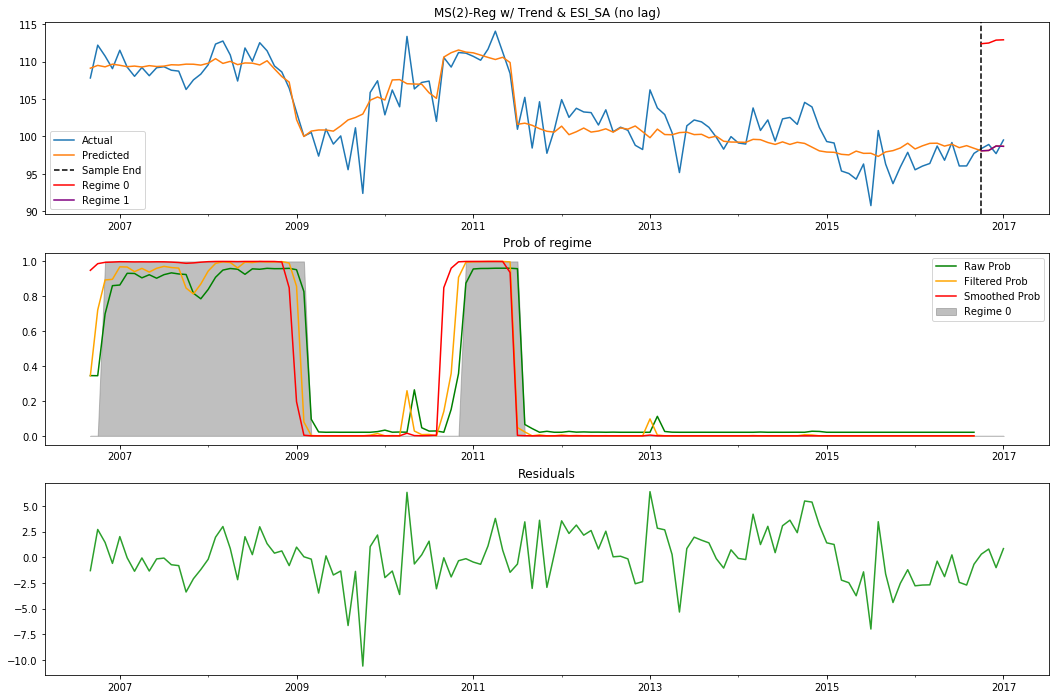

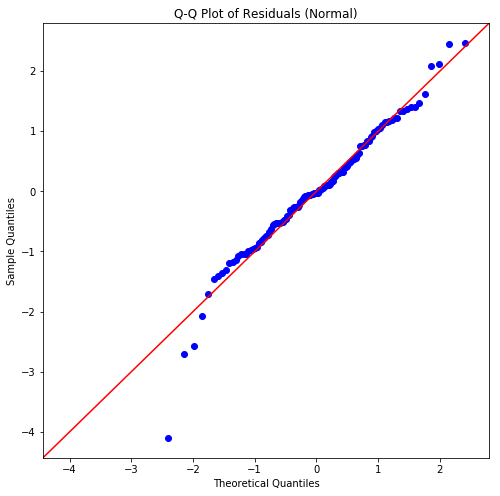

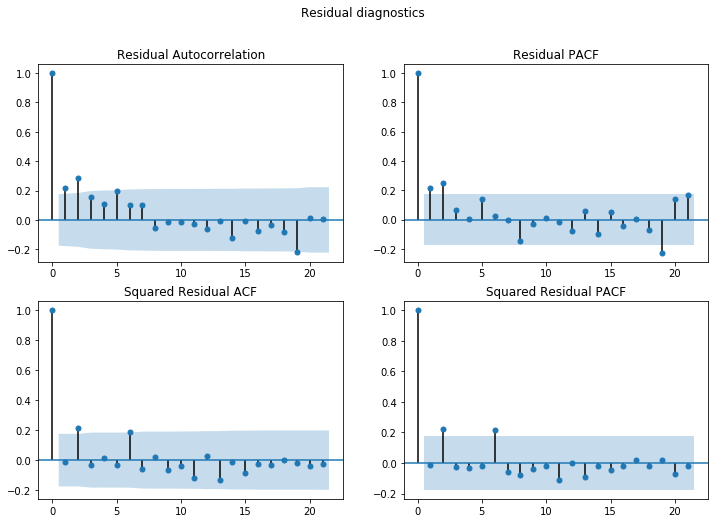

In [21]:
all_trend_esi0 = do_everything(
    exog_vars=["t", "esi_sa"],
    plot_title="MS(2)-Reg w/ Trend & ESI_SA (no lag)",
    output_to=path_output / "trend_esi_0",
)
all_trend_esi0['summary']

## Trend and ESI_SA\[-4\]

Optimization terminated successfully.
         Current function value: 2.404560
         Iterations: 34
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 gdp_sa   No. Observations:                  121
Model:               MarkovRegression   Log Likelihood                -290.952
Date:                Thu, 06 Feb 2020   AIC                            599.903
Time:                        02:34:05   BIC                            625.066
Sample:                    09-01-2006   HQIC                           610.123
                         - 09-01-2016                                         
Covariance Type:               approx                                         
               Variable information              
=================================================
Variable                   Name                  
-------------------------------------------------
   const                                 Constant
      x1                         Linear trend (t)
      x2 GESI_SA[-4] (seasonally adjusted by X13)
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.9190      3.922     25.224      0.000      91.233     106.605
x1            -0.1169      0.011    -10.570      0.000      -0.139      -0.095
x2             0.1118      0.035      3.206      0.001       0.043       0.180
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.7080      3.186     23.132      0.000      67.463      79.953
x1            -0.0622      0.015     -4.048      0.000      -0.092      -0.032
x2             0.3569      0.032     11.006      0.000       0.293       0.420
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.6310      0.874      6.445      0.000       3.919       7.343
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9288      0.051     18.228      0.000       0.829       1.029
p[1->0]        0.1163      0.076      1.536      0.124      -0.032       0.265
          Other regime information          
============================================
Regime Ergodic probability Expected Duration
--------------------------------------------
     0                0.62            14.048
     1                0.38             8.599
  Other statistics 
===================
  Statistic   Value
-------------------
Durbin-Watson 2.008
-------------------


"""

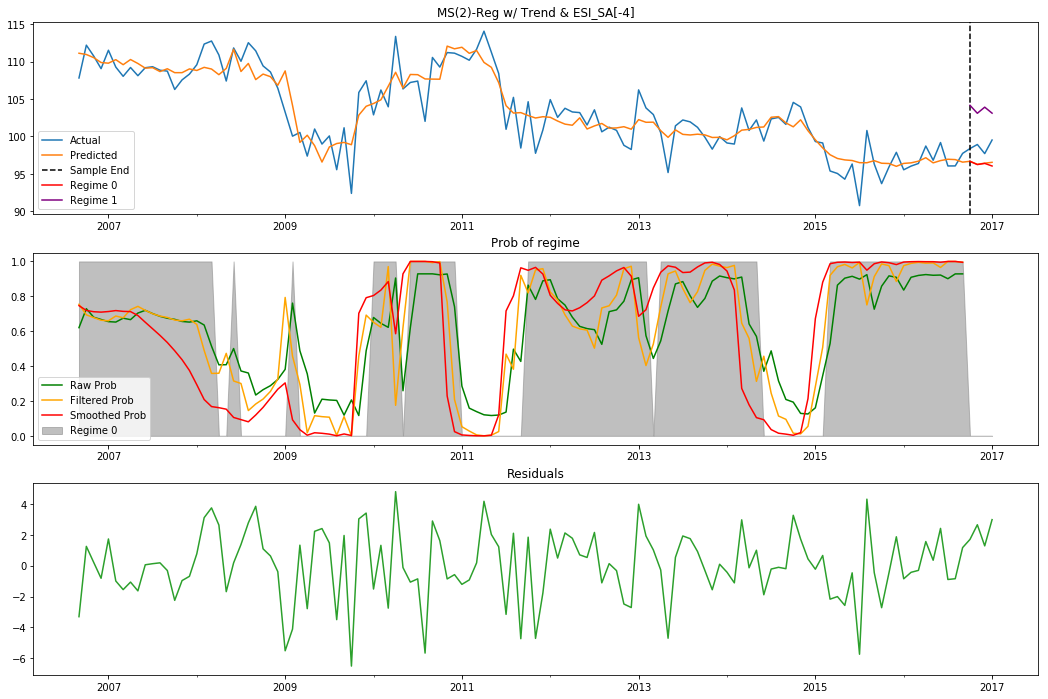

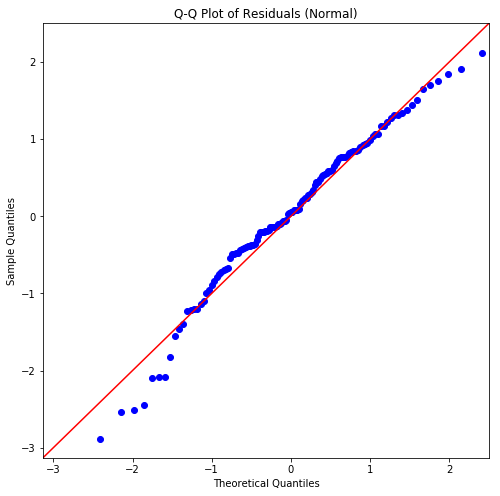

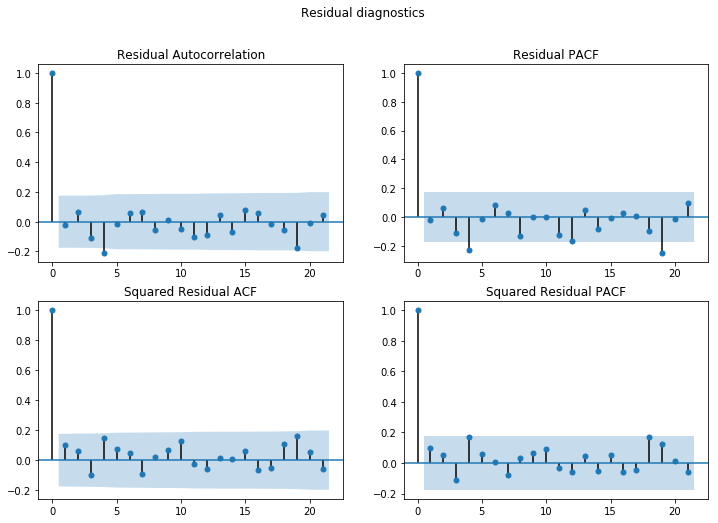

In [22]:
all_trend_esi4 = do_everything(
    exog_vars=["t", "esi_sa_4"],
    plot_title="MS(2)-Reg w/ Trend & ESI_SA[-4]",
    output_to=path_output / "trend_esi_4",
)
all_trend_esi4['summary']